In [1]:
from google.colab import drive
drive.mount('/content/drive')

import sys
sys.path.append('/content/drive/MyDrive/project_Yuming/codes')

Mounted at /content/drive


In [2]:
%%capture
!pip install ipython-autotime
!pip install torchdiffeq
!sudo apt install texlive texlive-latex-extra texlive-fonts-recommended dvipng
!pip install latex
!sudo apt-get install texlive-latex-extra texlive-fonts-recommended dvipng cm-super
%load_ext autotime
%matplotlib inline

time: 1.78 ms (started: 2021-06-06 07:03:26 +00:00)


In [3]:
import utils
from core_training import train_loop_diff, train_loop_em_new
from viz_loss import loss_grad_vis_1d, loss_grad_vis_2d
# from tqdm import tqdm
from tqdm.auto import tqdm

from models import DEModel, DAModel, NNModel, Noise

# reflect real-time changes in other modules
import importlib
importlib.reload(utils)
importlib.reload(DEModel)
importlib.reload(DAModel)
importlib.reload(NNModel)
importlib.reload(Noise)

from utils import Timer
import copy
import math
import random
import torch
import torch.nn as nn
import numpy as np
from scipy.integrate import solve_ivp
from torchdiffeq import odeint_adjoint
from torchdiffeq import odeint

import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib as mpl
from matplotlib import rc

from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device="cpu"
print(f"device: {device}")

device: cpu
time: 6.6 s (started: 2021-06-06 07:03:26 +00:00)


#1 Parameter

In [95]:
n_runs = 10
sigma_list = 15 + 3*torch.randn(n_runs, device=device)
beta_list = torch.max(8/3 + 3*torch.randn(n_runs, device=device), torch.tensor([0.], device=device))
rho_list = 20 + 3*torch.randn(n_runs, device=device)
coeff_list = torch.stack((sigma_list, beta_list, rho_list), dim=1)
print(coeff_list)
print(coeff_list.mean(dim=0))

tensor([[13.2927,  4.0665, 23.7885],
        [19.0257,  5.8883, 12.8158],
        [12.1136,  1.3461, 25.3347],
        [15.0355,  0.3605, 22.1292],
        [12.7651,  0.0000, 21.1736],
        [15.2129,  3.2517, 18.2431],
        [16.0504,  0.9932, 21.4741],
        [10.9733,  0.1941, 19.2301],
        [12.7738,  0.0000, 19.9656],
        [13.4167,  0.0000, 19.5949]])
tensor([14.0660,  1.6101, 20.3750])
time: 11.3 ms (started: 2021-06-03 22:17:50 +00:00)


In [104]:
Q_list = utils.softplus(6 * torch.rand(n_runs) - 3).expand(3,n_runs).t()

tensor([[0.1891, 0.1891, 0.1891],
        [0.2034, 0.2034, 0.2034],
        [0.3745, 0.3745, 0.3745],
        [0.4442, 0.4442, 0.4442],
        [0.1287, 0.1287, 0.1287],
        [0.3861, 0.3861, 0.3861],
        [2.4506, 2.4506, 2.4506],
        [2.8484, 2.8484, 2.8484],
        [0.8366, 0.8366, 0.8366],
        [0.1065, 0.1065, 0.1065]])

time: 11.8 ms (started: 2021-06-03 22:22:23 +00:00)


In [13]:
importlib.reload(sys.modules['core_training'])
importlib.reload(NNModel)
importlib.reload(DAModel)
from core_training import train_loop_diff, train_loop_em_new


seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

x_dim = 3
true_coeff = torch.tensor([10., 8/3, 28.])
true_ode_func = NNModel.Lorenz63(true_coeff, x_dim)

init_m = torch.zeros(x_dim, device=device)
init_C_param = Noise.AddGaussian(x_dim, torch.tensor(10.), 'scalar')
train_and_test = 3
train_size = 2
with torch.no_grad():
  u0_warmup = torch.distributions.MultivariateNormal(torch.zeros(x_dim, device=device), covariance_matrix=100 * torch.eye(x_dim, device=device)).sample().to(device) # <-
  t_warmup = torch.cat((torch.tensor([0.]),60*torch.arange(1, train_and_test+1))).to(device)
  out_warmup = odeint(true_ode_func, u0_warmup, t_warmup, method='rk4', options=dict(step_size=0.05))
  u0 = out_warmup[1:]  # (*bs, x_dim)

with torch.no_grad():
  u0_warmup = torch.distributions.MultivariateNormal(torch.zeros(x_dim, device=device), covariance_matrix=100 * torch.eye(x_dim, device=device)).sample((50,)).to(device) # <-
  t_warmup = torch.cat((torch.tensor([0.]), torch.arange(80.,500.,20.))).to(device)
  out_warmup = odeint(true_ode_func, u0_warmup, t_warmup, method='rk4', options=dict(step_size=0.05))
  u0_test = out_warmup[1:].reshape(-1,x_dim)  # (*bs, x_dim)
  print(u0_test.shape)

t0 = 0.
t_obs_step = 0.2
t_obs_end = 30.
t_obs = torch.arange(t0, t_obs_end+t_obs_step, t_obs_step)[1:].to(device)

model_Q_true = Noise.AddGaussian(x_dim, torch.tensor(math.sqrt(0.5)), param_type='scalar')

indices = [0,1,2]
y_dim = len(indices)
H_true = torch.eye(x_dim)[indices]
true_obs_func = NNModel.Linear(x_dim, y_dim, H=H_true).to(device)

noise_R_true = Noise.AddGaussian(y_dim, torch.tensor(math.sqrt(2)), param_type='scalar')

with torch.no_grad():
  out, y_obs, out_intermediate, t_intermediate = DEModel.generate_data(true_ode_func, true_obs_func, t_obs, u0, model_Q_true, noise_R_true, 
                                                device=device, ode_method='rk4', ode_options=dict(step_size=0.05), adjoint=False, save_intermediate_step=True, t0=0., time_varying_obs=False)

enkf_kwargs = dict(ode_method='rk4', ode_options=dict(step_size=0.05), adjoint=True, adjoint_method='rk4', adjoint_options=dict(step_size=0.05),save_intermediate_step=True, smooth_lag=0,
          var_inflation=None, localization_radius=None, compute_likelihood=True, likelihood_warmup=0, 
          linear_obs=True, time_varying_obs=False, save_first=True, simulation_type=0)

def monitor(ode_func, model_Q_param, noise_R_param, neg_log_likelihood, test_neg_log_likelihood, test_mse, one_step_fs, nll_suro_em, algorithm, device):
  res = torch.zeros(0, device=device)
  res = torch.cat((res, ode_func.coeff.detach().clone().view(-1)))
  res = torch.cat((res, torch.sqrt(utils.mse_loss(ode_func.coeff, true_coeff)).detach().clone().view(-1)))
  res = torch.cat((res, model_Q_param.full().detach().clone().view(-1)))
  res = torch.cat((res, (torch.linalg.norm(model_Q_param.full() - model_Q_true.full(), 'fro', dim=(-1,-2))).detach().clone().view(-1)))
  # res = torch.cat((res, noise_R_param.q_true().detach().clone().view(-1)))
  res = torch.cat((res, neg_log_likelihood.mean().detach().clone().view(-1)))
  # if algorithm == "em":
  #   res = torch.cat((res, nll_suro_em.mean().detach().clone().view(-1)))
  return res.unsqueeze(dim=0)

# coeff_list = torch.tensor([[5., 5., 20.],
#                [12., 8., 18.],
#                [15., 0., 32.],
#                [5., 0., 32.]])
# Q_list = torch.tensor([[0.5, 0.5, 0.5],
#               [3., 3., 3.],
#               [0.1, 0.1, 0.1],
#               [2., 2., 2.]])

seed = 48
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

n_runs = 2
sigma_list = 15 + 3*torch.randn(n_runs, device=device)
beta_list = torch.max(8/3 + 3*torch.randn(n_runs, device=device), torch.tensor([0.], device=device))
rho_list = 20 + 3*torch.randn(n_runs, device=device)
coeff_list = torch.stack((sigma_list, beta_list, rho_list), dim=1)
Q_list = utils.softplus(6 * torch.rand(n_runs) - 3).expand(3,n_runs).t()

# coeff_list = torch.tensor([[15.,0.,20.]]).repeat(1,1)
# Q_list = 2 * torch.ones(1, 3)
N_ensem = 25

save = False
save_location = f"/content/drive/MyDrive/project_Yuming/codes/final_figures/Lorenz63/"
prefix = f"N_{N_ensem}_param_"

enkf_kwargs['likelihood_warmup']=0
monitor_EnKF = torch.zeros(0, device=device)
for iter in range(coeff_list.shape[0]):#iter in range(1): 
  learned_ode_func = NNModel.Lorenz63(coeff_list[iter].detach().clone(), x_dim).to(device)
  learned_model_Q = Noise.AddGaussian(x_dim, Q_list[iter].detach().clone()*torch.eye(x_dim), 'tril').to(device)
  optimizer = torch.optim.Adam([{'params':learned_ode_func.parameters(), 'lr':1e-1},
                             {'params':learned_model_Q.parameters(), 'lr':1e-1}])
  scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer,  gamma=0.98)
  monitor_res = train_loop_diff(learned_ode_func, true_obs_func, t_obs, y_obs, out, out_intermediate, N_ensem, init_m, init_C_param, learned_model_Q, noise_R_true, device, optimizer,proposal='optimal', adaptive_resampling=False, n_epochs=75, 
                                scheduler=scheduler, batch_length=30, bs=1, print_every_n_epochs=None, test_every_n_epochs=1000, tbptt=3, method='enkf', train_size=train_size, clip_norm=None, 
                                true_system="L63", true_ode_func=true_ode_func, u0_test=u0_test, monitor=monitor, timer=True, lr_decay=None,**enkf_kwargs)
  monitor_EnKF = torch.cat((monitor_EnKF, monitor_res.unsqueeze(0)))
if save:
  torch.save({'monitor': monitor_EnKF, 'learned_ode_func':learned_ode_func.state_dict(), 'learned_model_Q':learned_model_Q.state_dict()},save_location+prefix+"EnKF")

enkf_kwargs['likelihood_warmup']=0
monitor_EM = torch.zeros(0, device=device)
for iter in range(coeff_list.shape[0]):
  learned_ode_func = NNModel.Lorenz63(coeff_list[iter].detach().clone(), x_dim).to(device)
  learned_model_Q = Noise.AddGaussian(x_dim, Q_list[iter].detach().clone(), 'diag').to(device)
  # learned_model_Q = utils.softplus_inv(0.1*torch.ones(x_dim, device=device))
  optimizer = torch.optim.Adam([{'params':learned_ode_func.parameters(), 'lr':1e-1}])
                            #  {'params':learned_model_Q.parameters(), 'lr':1e-1}])
  # optimizer = torch.optim.Adam([{'params':learned_ode_func.parameters(), 'lr':1e-1}])
  scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer,  gamma=0.98)
  monitor_res, learned_model_Q = train_loop_em_new(learned_ode_func, true_obs_func, t_obs, y_obs, out, out_intermediate, N_ensem, init_m, init_C_param, learned_model_Q, noise_R_true, device, optimizer, n_epochs=75, 
                              scheduler=scheduler, batch_length=30, bs=1, print_every_n_epochs=None, test_every_n_epochs=1000, train_size=train_size, m_step_type="mean", m_steps=3,
                              track_Q='full', true_system="L63", true_ode_func=true_ode_func, u0_test=u0_test, monitor=monitor, timer=True, lr_decay=None,**enkf_kwargs)
  monitor_EM = torch.cat((monitor_EM, monitor_res.unsqueeze(0)))
if save:
  torch.save({'monitor': monitor_EM, 'learned_ode_func':learned_ode_func.state_dict(), 'learned_model_Q':learned_model_Q.state_dict()},save_location+prefix+"EM")

monitor_PF = torch.zeros(0, device=device)
for iter in range(coeff_list.shape[0]):#iter in range(1): 
  learned_ode_func = NNModel.Lorenz63(coeff_list[iter].detach().clone(), x_dim).to(device)
  learned_model_Q = Noise.AddGaussian(x_dim, Q_list[iter].detach().clone()*torch.eye(x_dim), 'tril').to(device)  
  optimizer = torch.optim.Adam([{'params':learned_ode_func.parameters(), 'lr':1e-1},
                             {'params':learned_model_Q.parameters(), 'lr':1e-1}])
  # optimizer = torch.optim.Adam([{'params':learned_ode_func.parameters(), 'lr':1e-1}])
  scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer,  gamma=0.98)
  monitor_res = train_loop_diff(learned_ode_func, true_obs_func, t_obs, y_obs, out, out_intermediate, N_ensem, init_m, init_C_param, learned_model_Q, noise_R_true, device, optimizer,proposal='optimal', adaptive_resampling=True, n_epochs=75, 
                                scheduler=scheduler, batch_length=30, bs=1, print_every_n_epochs=None, test_every_n_epochs=1000, tbptt=3, method='pf', detach_every=None, train_size=train_size, clip_norm=None, 
                                true_system="L63", true_ode_func=true_ode_func, u0_test=u0_test, monitor=monitor, timer=True, lr_decay=None, **enkf_kwargs)
  monitor_PF = torch.cat((monitor_PF, monitor_res.unsqueeze(0)))
if save:
  torch.save({'monitor': monitor_PF, 'learned_ode_func':learned_ode_func.state_dict(), 'learned_model_Q':learned_model_Q.state_dict()},save_location+prefix+"PF")

torch.Size([1050, 3])
Filter, Elapsed: 2.997332811355591s
Epoch 0: nll = -1792.44384765625, test_nll = -1118.33642578125
tensor([[ 1.6330e+01,  2.8397e+00,  2.6146e+01,  3.8094e+00,  7.0077e-02,
         -3.6634e-01,  2.7451e-01, -3.6634e-01,  2.7935e+00, -4.3890e-01,
          2.7451e-01, -4.3890e-01,  3.6976e+00,  4.0588e+00, -1.7924e+03]])
Filter, Elapsed: 2.9953131675720215s
Epoch 1: nll = -1042.52392578125, test_nll = -1118.33642578125
tensor([[ 1.2712e+01,  2.7825e+00,  2.7266e+01,  1.6236e+00,  6.5027e-02,
         -3.0305e-01,  2.2806e-01, -3.0305e-01,  2.2544e+00, -1.2926e-01,
          2.2806e-01, -1.2926e-01,  3.2446e+00,  3.3348e+00, -1.0425e+03]])
Filter, Elapsed: 2.985992670059204s
Epoch 2: nll = -980.2571411132812, test_nll = -1118.33642578125
tensor([[ 1.0354e+01,  2.7698e+00,  2.7838e+01,  2.3232e-01,  3.6923e-02,
         -1.6470e-01,  1.2238e-01, -1.6470e-01,  1.4853e+00,  4.7043e-02,
          1.2238e-01,  4.7043e-02,  1.9427e+00,  1.8317e+00, -9.8026e+02]])
Filter,

In [9]:
d_EnKF = torch.load(f"/content/drive/MyDrive/project_Yuming/codes/final_figures/Lorenz63/N_25_param_EnKF")
monitor_EnKF = d_EnKF['monitor']
learned_ode_func = NNModel.Lorenz63(coeff_list[0].detach().clone(), x_dim).to(device)
learned_model_Q = Noise.AddGaussian(x_dim, Q_list[0].detach().clone()*torch.eye(x_dim), 'tril').to(device)  
learned_ode_func.load_state_dict(d_EnKF['learned_ode_func'])
learned_model_Q.load_state_dict(d_EnKF['learned_model_Q'])

d_EM = torch.load(f"/content/drive/MyDrive/project_Yuming/codes/final_figures/Lorenz63/N_25_param_EM")
monitor_EM = d_EM['monitor']
learned_ode_func = NNModel.Lorenz63(coeff_list[0].detach().clone(), x_dim).to(device)
learned_model_Q = Noise.AddGaussian(x_dim, Q_list[0].detach().clone()*torch.eye(x_dim), 'tril').to(device)  
learned_ode_func.load_state_dict(d_EM['learned_ode_func'])
learned_model_Q.load_state_dict(d_EM['learned_model_Q'])

d_PF = torch.load(f"/content/drive/MyDrive/project_Yuming/codes/final_figures/Lorenz63/N_25_param_PF")
monitor_PF = d_PF['monitor']
learned_ode_func = NNModel.Lorenz63(coeff_list[0].detach().clone(), x_dim).to(device)
learned_model_Q = Noise.AddGaussian(x_dim, Q_list[0].detach().clone()*torch.eye(x_dim), 'tril').to(device)  
learned_ode_func.load_state_dict(d_PF['learned_ode_func'])
learned_model_Q.load_state_dict(d_PF['learned_model_Q'])

<All keys matched successfully>

time: 412 ms (started: 2021-06-05 06:14:57 +00:00)


In [40]:
%%capture
!pip install pdfo

time: 55.8 s (started: 2021-06-03 20:45:40 +00:00)


In [ ]:
from pdfo import pdfo, newuoa, Bounds, LinearConstraint, NonlinearConstraint

def obj(x):
  with torch.no_grad():
    coeff = x[:3].astype(np.float32)
    # Q = x[3:].reshape(3, 3).astype(np.float32)
    # Q = x[3:].astype(np.float32)
    learned_ode_func = NNModel.Lorenz63(torch.from_numpy(coeff).detach().clone(), x_dim).to(device)
    # learned_model_Q = Noise.AddGaussian(x_dim, torch.from_numpy(Q).detach().clone(), 'diag').to(device) 
    # print(1,end =" ")
    print(learned_ode_func.coeff)
    # print(learned_model_Q.full())
    _, X_track_test, _, test_neg_log_likelihood = DAModel.EnKF(learned_ode_func, true_obs_func, t_obs, y_obs[:,:8], 1000, init_m, init_C_param, model_Q_true, noise_R_true, device, **enkf_kwargs)
    # _, _, X_track_test, _, _, _, test_neg_log_likelihood = DAModel.BootstrapPF(learned_ode_func, true_obs_func, t_obs, y_obs[:,:8], 1000, init_m, init_C_param, learned_model_Q, noise_R_true, device, proposal='optimal', **enkf_kwargs)
    return test_neg_log_likelihood.mean().item() 

import numpy as np
from scipy.optimize import minimize

x0 = np.array([10., 2., 25.])
res = pdfo(obj, x0) 
print(res)


findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


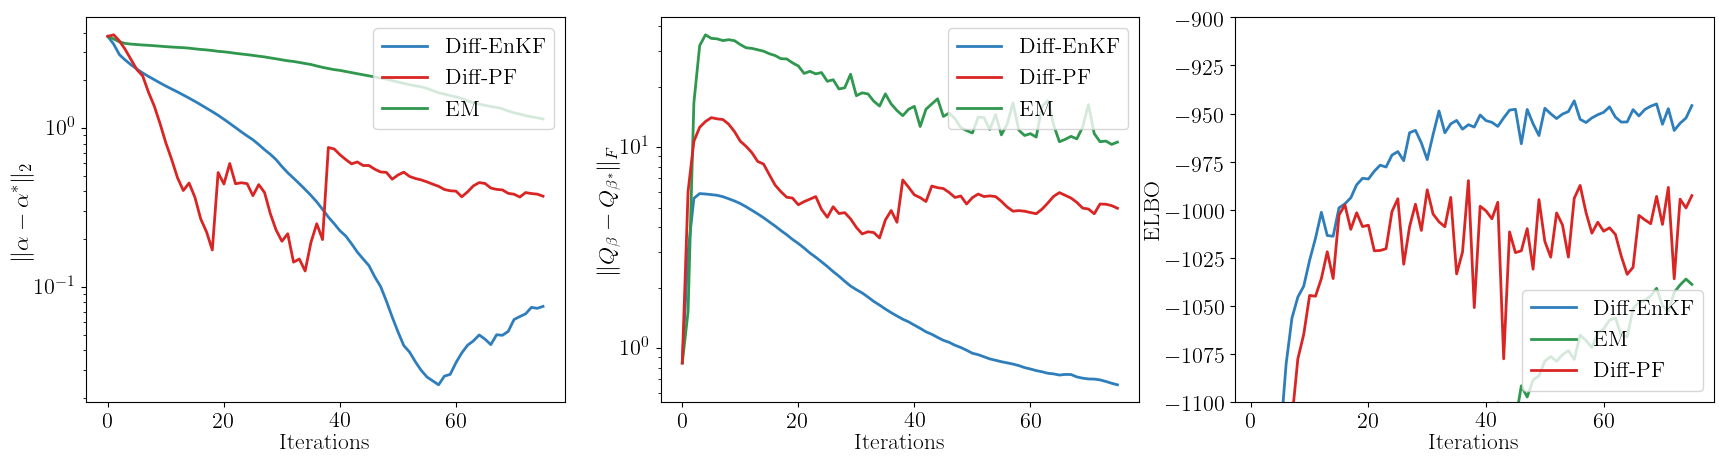

time: 3.22 s (started: 2021-06-06 07:51:35 +00:00)


In [7]:
importlib.reload(utils)

mpl.rc_file_defaults()
rc('font', **{'family':'serif','serif':'Computer Modern'})
rc('text', usetex=True)
mpl.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}']
mpl.rcParams['axes.titlesize']= 24
# mpl.rcParams['axes.grid']= True
mpl.rcParams['axes.labelsize'] = 17
mpl.rcParams['axes.labelpad'] = 1
# mpl.rcParams['lines.linewidth'] = 10
mpl.rcParams['lines.markersize'] = 10
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize']= 16
mpl.rcParams['legend.fontsize']= 16


def custom_axes(axes, ax_d):
  axes[0,0].set_xlabel(r"Iterations")
  axes[0,1].set_xlabel(r"Iterations")
  axes[0,2].set_xlabel(r"Iterations")
  axes[0,0].set_ylabel(r"$\| \alpha - \alpha^*\|_2$")
  axes[0,1].set_ylabel(r"$\| Q_\beta - Q_{\beta^*} \|_F$")
  axes[0,2].set_ylabel(r"ELBO")
  axes[0,2].legend(loc='lower right')
  # legend_order=[0,1,2]
  # handles, labels = utils.unique_labels(axes[0,1])
  # axes[0,1].legend([handles[idx] for idx in legend_order],[labels[idx] for idx in legend_order], loc='upper right')
  # handles, labels = utils.unique_labels(axes[1,1])
  # axes[1,1].legend([handles[idx] for idx in legend_order],[labels[idx] for idx in legend_order], loc='upper right')
  # legend_order=[0,1,2]
  # handles, labels = utils.unique_labels(axes[0,2])
  # axes[0,2].legend([handles[idx] for idx in legend_order],[labels[idx] for idx in legend_order], loc='lower right')
  # handles, labels = utils.unique_labels(axes[1,2])
  # axes[1,2].legend([handles[idx] for idx in legend_order],[labels[idx] for idx in legend_order], loc='lower right')
  # axes[1,0].set_ylim(-1000,-700)
  # axes[1,0].set_ylim(-0.1,0.2)
  # axes[0,0].set_ylim(9,11)
  # axes[0,1].set_ylim(2,3.5)
  # axes[0,2].set_ylim(27,29)
  axes[0,2].set_ylim(-1100,-900)
  return

# monitor_KF_truths=monitor_KF[0,-1,:]
monitor_EnKF_new=monitor_EnKF.detach().clone()
monitor_EM_new=monitor_EM.detach().clone()
monitor_PF_new=monitor_PF.detach().clone()

# monitor_EnKF_new = torch.cat((monitor_EnKF_new, utils.flat2matrix(monitor_EnKF_new[:,:,3:12], truth=model_Q_true.full()).unsqueeze(-1)), dim=-1)
# monitor_EM_new = torch.cat((monitor_EM_new, utils.flat2matrix(monitor_EM_new[:,:,3:12], truth=model_Q_true.full()).unsqueeze(-1)), dim=-1)
# monitor_PF_new = torch.cat((monitor_PF_new, utils.flat2matrix(monitor_PF_new[:,:,3:12], truth=model_Q_true.full()).unsqueeze(-1)), dim=-1)
# monitor_EnKF_new[:,:,0]=torch.abs(monitor_EnKF_new[:,:,0]-monitor_KF_truths[0])
# monitor_PF_new[:,:,0]=torch.abs(monitor_PF_new[:,:,0]-monitor_KF_truths[0])


save_location=None
load_location=None
# save_location = f"/content/drive/MyDrive/project_Yuming/codes/final_figures/Lorenz63/param_est"
# load_location = f"/content/drive/MyDrive/project_Yuming/codes/final_figures/Lorenz63/param_est"

# monitor_res = [monitor_KF,monitor_EnKF, monitor_PF]
monitor_res = [monitor_EnKF_new,monitor_EM_new,monitor_PF_new]#,monitor_PF-monitor_KF]
# monitor_res = [(monitor_EnKF-monitor_KF)/torch.abs(monitor_KF),(monitor_PF-monitor_KF)/torch.abs(monitor_KF)]
# methods = [ r"Truth",r"EnKF",  r"PF",]
methods = [ r"Diff-EnKF",r"EM",r"Diff-PF"]
# titles = ["Likelihood estimate", "grad"]
titles = [None] * 20
# truths = [None,math.sqrt(0.5),None,0.42,math.sqrt(0.01),None]
truths = [10,8/3,28] + [None] * 20
truths_legends = ['t','t',None,'t','t',None]
# truths2 = [None, monitor_KF_truths[1]**2, monitor_KF_truths[2]] + [None, monitor_KF_truths[4]**2, monitor_KF_truths[5]]
truths2 = [None] * 20
truths2_legends = None

groups = [(4,13)]
plots_to_show = {3,5,6}
logscale={0,1}#{0,1,2}
logscalex={}
legend_order=None
utils.plot_monitor_res_new(monitor_res, methods, titles, truths, logscale, logscalex, truths_legends=truths_legends, truths2=truths2, truths2_legends=truths2_legends, start_from_one={2}, legend_order=legend_order, groups=groups,
                           error_bar=True, error_bar_style="quantile", n_cols=3,subplot_width=7, subplot_height=5,linewidth=2, plots_to_show=plots_to_show, x_axiss=None, custom_axes=custom_axes, save_location=save_location, load_location=load_location)

In [54]:
monitor_EM[:,-1,13]

tensor([13.0509, 10.0867, 10.1876, 12.7467, 14.2810, 13.3174,  9.3771, 12.6550,
        69.7735, 10.1895, 11.0385, 11.2104, 11.3747,  9.8595, 88.0528])

time: 7.38 ms (started: 2021-06-05 06:39:47 +00:00)


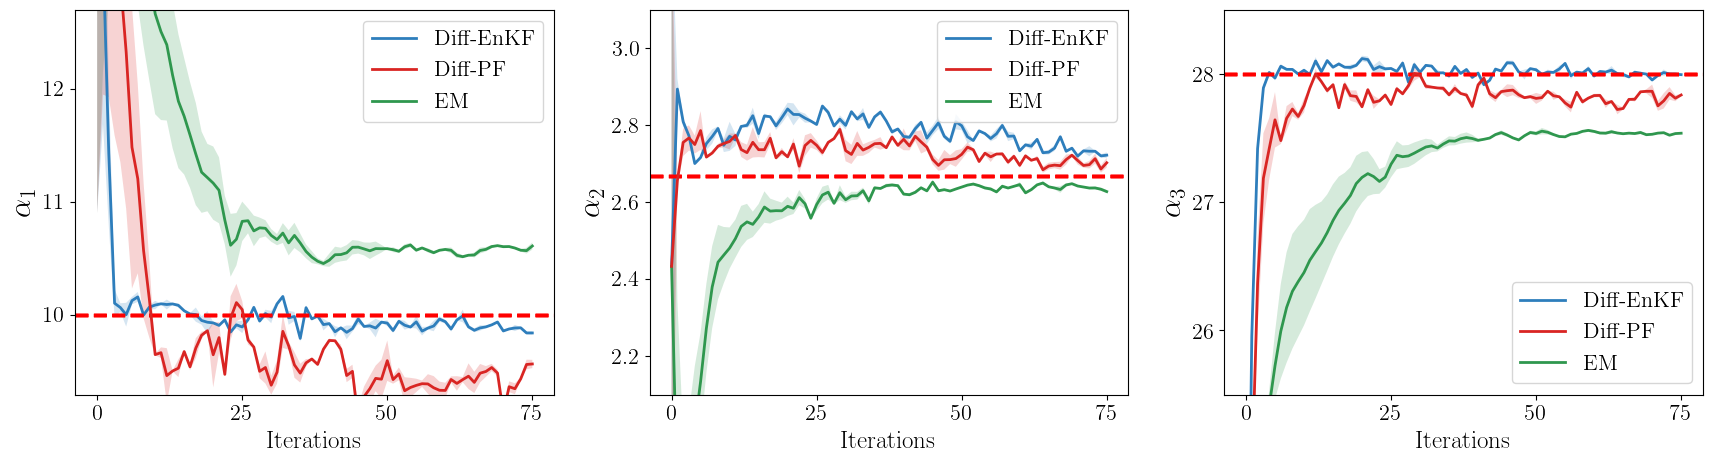

time: 569 ms (started: 2021-06-06 08:53:53 +00:00)


In [14]:
importlib.reload(utils)

mpl.rc_file_defaults()
rc('font', **{'family':'serif','serif':'Computer Modern'})
rc('text', usetex=True)
mpl.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}']
mpl.rcParams['axes.titlesize']= 24
# mpl.rcParams['axes.grid']= True
mpl.rcParams['axes.labelsize'] = 22
mpl.rcParams['axes.labelpad'] = 5
# mpl.rcParams['lines.linewidth'] = 10
mpl.rcParams['lines.markersize'] = 10
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize']= 16
mpl.rcParams['legend.fontsize']= 16


def custom_axes(axes, ax_d):

  # axes[0,0].set_ylim(8.6,15.4)
  # axes[0,0].yaxis.set_ticks(np.linspace(9, 15, 4))
  axes[0,0].set_xlabel(r"Iterations", fontsize=18)
  axes[0,0].set_ylabel(r"$\alpha_1$")
  axes[0,1].set_xlabel(r"Iterations", fontsize=18)
  axes[0,1].set_ylabel(r"$\alpha_2$")
  axes[0,2].set_xlabel(r"Iterations", fontsize=18)
  axes[0,2].set_ylabel(r"$\alpha_3$")
  axes[0,0].set_ylim(9.3,12.7)
  axes[0,0].yaxis.set_ticks(np.linspace(10, 12, 3))
  axes[0,1].set_ylim(2.1,3.1)
  axes[0,2].set_ylim(25.5,28.5)
  axes[0,2].yaxis.set_ticks(np.linspace(26,28,3))
  handles, labels = utils.unique_labels(axes[0,2])
  legend_order=[0,1,2]
  axes[0,2].legend([handles[idx] for idx in legend_order],[labels[idx] for idx in legend_order], loc='lower right')  
  # axes[1,2].set_ylim(-1000,-900)

  axes[0,0].xaxis.set_ticks(np.linspace(0, 75, 4))
  axes[0,1].xaxis.set_ticks(np.linspace(0, 75, 4))
  axes[0,2].xaxis.set_ticks(np.linspace(0, 75, 4))
  return

monitor_EnKF_new=monitor_EnKF.detach().clone()
monitor_EM_new=monitor_EM.detach().clone()
monitor_PF_new=monitor_PF.detach().clone()

save_location=None
load_location=None
# save_location = f"/content/drive/MyDrive/project_Yuming/codes/final_figures/Lorenz63/param_est"

monitor_res = [monitor_EnKF_new,monitor_EM_new,monitor_PF_new]#,monitor_PF-monitor_KF]
methods = [ r"Diff-EnKF",r"EM",r"Diff-PF"]
titles = [None] * 20
truths = [10,8/3,28] + [None] * 20
truths_legends = None#['t','t',None,'t','t',None]
truths2 = [None] * 20
truths2_legends = None

groups = [(4,13)]
plots_to_show = {0, 1, 2}
logscale={}#{0,1,2}
logscalex={}
legend_order=None
utils.plot_monitor_res_new(monitor_res, methods, titles, truths, logscale, logscalex, truths_legends=truths_legends, truths2=truths2, truths2_legends=truths2_legends, start_from_one={5}, legend_order=legend_order, groups=groups,
                           error_bar=True, error_bar_style="quantile", n_cols=3,subplot_width=7, subplot_height=5,linewidth=2, plots_to_show=plots_to_show, x_axiss=None, custom_axes=custom_axes, save_location=save_location, load_location=load_location)

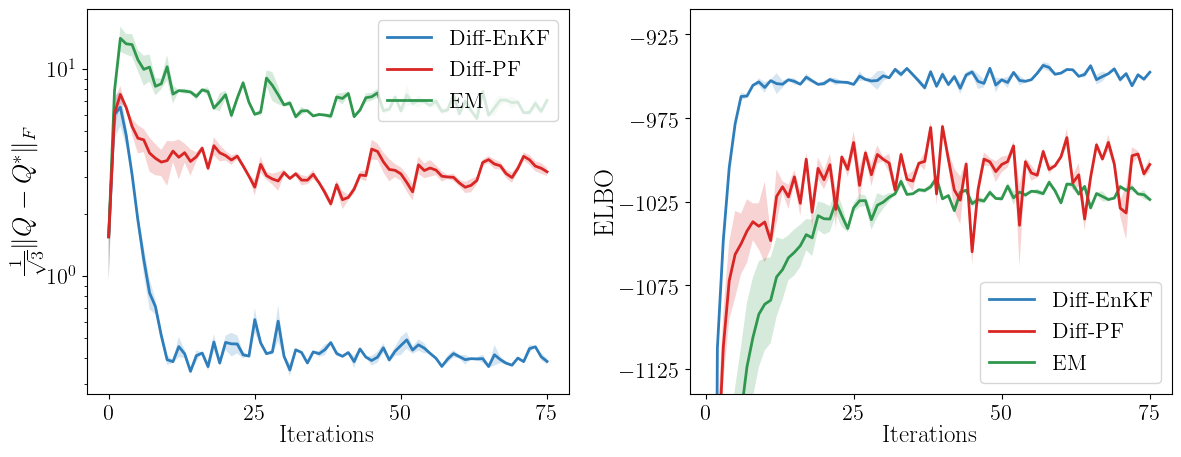

time: 914 ms (started: 2021-06-06 08:17:42 +00:00)


In [12]:
importlib.reload(utils)

mpl.rc_file_defaults()
rc('font', **{'family':'serif','serif':'Computer Modern'})
rc('text', usetex=True)
mpl.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}']
mpl.rcParams['figure.subplot.wspace'] = 0.25

mpl.rcParams['axes.titlesize']= 24
# mpl.rcParams['axes.grid']= True
mpl.rcParams['axes.labelsize'] = 19
mpl.rcParams['axes.labelpad'] = 1
# mpl.rcParams['lines.linewidth'] = 10
mpl.rcParams['lines.markersize'] = 10
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize']= 16
mpl.rcParams['legend.fontsize']= 16


def custom_axes(axes, ax_d):

  # # axes[0,0].set_ylim(8.6,15.4)
  # # axes[0,0].yaxis.set_ticks(np.linspace(9, 15, 4))
  axes[0,0].set_xlabel(r"Iterations", fontsize=18)
  axes[0,0].set_ylabel(r"$\frac{1}{\sqrt{3}}\| Q - Q^* \|_F$")
  axes[0,1].set_xlabel(r"Iterations", fontsize=18)
  axes[0,1].set_ylabel(r"ELBO")
  # axes[0,0].set_ylim(9.3,12.7)
  # axes[0,0].yaxis.set_ticks(np.linspace(10, 12, 3))
  # axes[0,1].set_ylim(2.1,3.1)


  # # axes[1,2].set_ylim(-1000,-900)
  axes[0,1].set_ylim(-1140,-910)
  axes[0,1].yaxis.set_ticks(np.linspace(-1125, -925, 5))
  handles, labels = utils.unique_labels(axes[0,1])
  legend_order=[0,1,2]
  axes[0,1].legend([handles[idx] for idx in legend_order],[labels[idx] for idx in legend_order], loc='lower right')  
  
  axes[0,0].xaxis.set_ticks(np.linspace(0, 75, 4))
  axes[0,1].xaxis.set_ticks(np.linspace(0, 75, 4))
  return

monitor_EnKF_new=monitor_EnKF.detach().clone()
monitor_EM_new=monitor_EM.detach().clone()
monitor_PF_new=monitor_PF.detach().clone()
monitor_EnKF_new[:,:,13] = monitor_EnKF_new[:,:,13] / np.sqrt(x_dim)
monitor_EM_new[:,:,13] = monitor_EM_new[:,:,13] / np.sqrt(x_dim)
monitor_PF_new[:,:,13] = monitor_PF_new[:,:,13] / np.sqrt(x_dim)

save_location=None
load_location=None
save_location = f"/content/drive/MyDrive/project_Yuming/codes/final_figures/Lorenz63/param_est_contd"

monitor_res = [monitor_EnKF_new,monitor_EM_new,monitor_PF_new]#,monitor_PF-monitor_KF]
methods = [ r"Diff-EnKF",r"EM",r"Diff-PF"]
titles = [None] * 20
truths = [10,8/3,28] + [None] * 20
truths_legends = None#['t','t',None,'t','t',None]
truths2 = [None] * 20
truths2_legends = None

groups = [(4,13)]
plots_to_show = {5,6}
logscale={0}#{0,1,2}
logscalex={}
legend_order=None
utils.plot_monitor_res_new(monitor_res, methods, titles, truths, logscale, logscalex, truths_legends=truths_legends, truths2=truths2, truths2_legends=truths2_legends, start_from_one={1}, legend_order=legend_order, groups=groups,
                           error_bar=True, error_bar_style="quantile", n_cols=2,subplot_width=7, subplot_height=5,linewidth=2, plots_to_show=plots_to_show, x_axiss=None, custom_axes=custom_axes, save_location=save_location, load_location=load_location)

# 2. NN